# Homework 1 (Due Sep 23, 2025 by Noon) 


## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

You've learned how to create L- and M- estimators and use them to estimate the parameters of a model. Generally, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$
You can use one of the estimators we discussed in the lecture, but you should be aware that the dataset can have outliers. 


Once you write down the $\ln L$ in terms of the model parameters, $a$ and $b$, this is the expression that you now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements your favorite robust loss function, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with your likelihood function in the previous part, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [46]:
%matplotlib inline

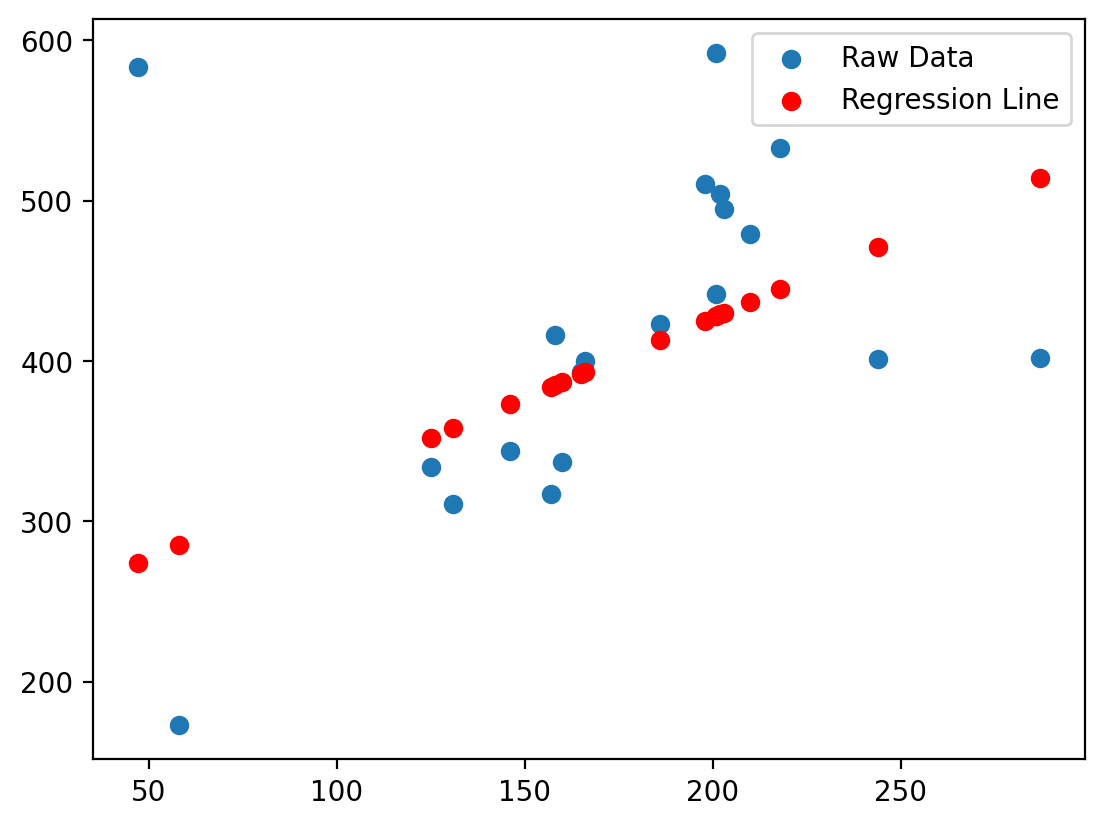

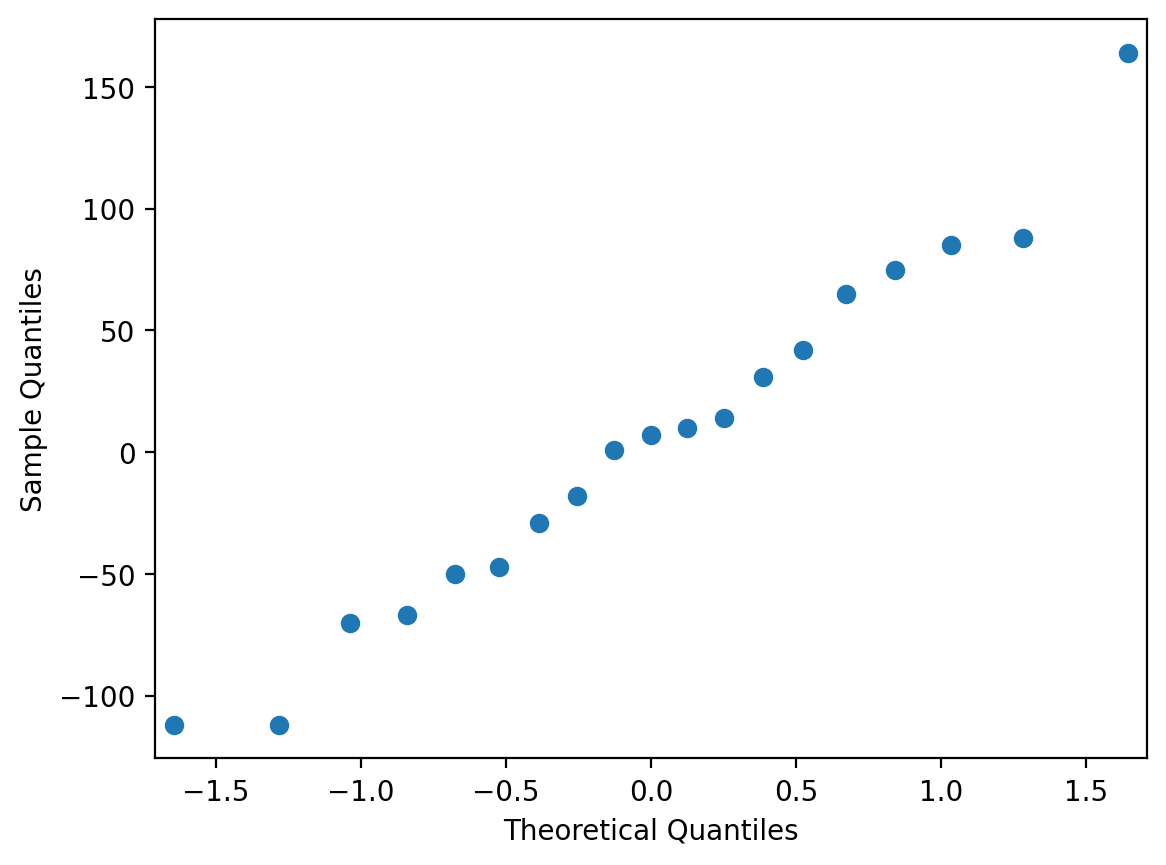

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test
import sys
import astropy
# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

def square_loss(y, y_hat):
    #Set square loss = 0
    square_loss = 0
    #Sum up all the (y_true - y_expected)^2
    for i in range(len(y)):
        #Incorporate dy as a weight to get uncertainty
        square_loss = square_loss + (((y[i] - y_hat[i])**2) / dy[i]**2)
    #Divide by the number of points, aka len(y)
    square_loss = square_loss / len(y)
    #Return it
    return(square_loss)

#Construct an algorithm to find the smallest square loss using parameters
square_loss_min = sys.maxsize
saved_m = 0
saved_b = 0
for m in range(-10,10):
    for b in range(0,500):
        if (square_loss(y, m*x+b) < square_loss_min):
            saved_m = m
            saved_b = b
            square_loss_min = square_loss(y, m*x+b)
                    
#Plot raw data
plt.scatter(x,y, label= 'Raw Data')

#Save for later
residuals = y - (saved_m * x + saved_b)

#Plot regression line
plt.scatter(x, saved_m * x + saved_b, color='red', label='Regression Line')
plt.legend()

#Sigma clip the residuals
sigma_clipped_y_data = astropy.stats.sigma_clip(residuals, masked=False)
sm.qqplot(sigma_clipped_y_data)


#From here, I'm going to get my likelihood function

#First get the addition sum part of it. I'd rather just get it right now and use it later 
add_sum_part = np.exp(-1/2 * np.sum((-residuals / dy)**2))

#Initialize the multiply sum term of the function
multiply_sum_part = 1/(dy[0]*np.sqrt(2*np.pi))

#Multiply the first term and so on by the next term
for i in range(1, len(y)):
    whatToMultiply = 1/(dy[i]*np.sqrt(2*np.pi))
    multiply_sum_part = multiply_sum_part * whatToMultiply

#Multiply both terms to finally get likelihood function
Likelihood_Function = multiply_sum_part * add_sum_part



## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)